Note: locate_cosmics was run in advance so this notebook is to clean up any residual cosmics. 

In [1]:
pwd

'/Users/james/JWSTdata/GJ341b/MAST_2023-03-12T0537/JWST/reduction01/reduction_notebooks'

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import reduction_utils.cosmic_removal as c
import reduction_utils.wavelength_calibration as wc

In [4]:
ls ../pickled_objects/

flux_base_level_right_star1.pickle  star1_flux.pickle
fwhm_1.pickle                       time.pickle
sky_avg_star1.pickle                x_positions_1.pickle
star1_error.pickle


In [5]:
s1 = pickle.load(open("../pickled_objects/star1_flux.pickle","rb"))
e1 = pickle.load(open("../pickled_objects/star1_error.pickle","rb"))

In [6]:
less ../extraction_input_v2.dat

In [7]:
s1.shape

(4652, 1230)

<IPython.core.display.Javascript object>


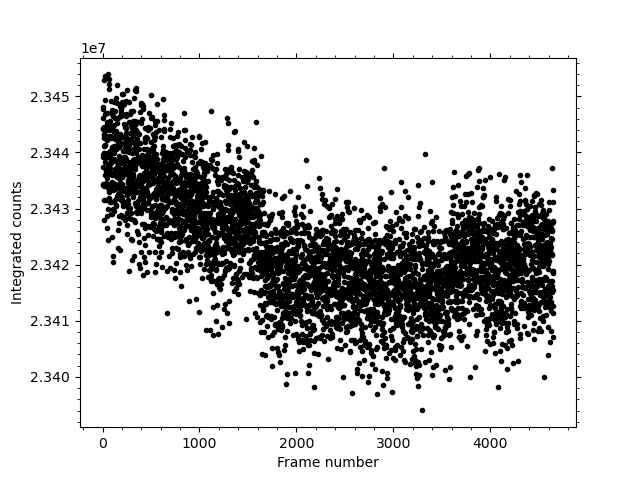

In [8]:
plt.figure()
plt.plot(s1.sum(axis=1),'k.')
plt.xlabel("Frame number")
plt.ylabel("Integrated counts")
plt.show()

<IPython.core.display.Javascript object>


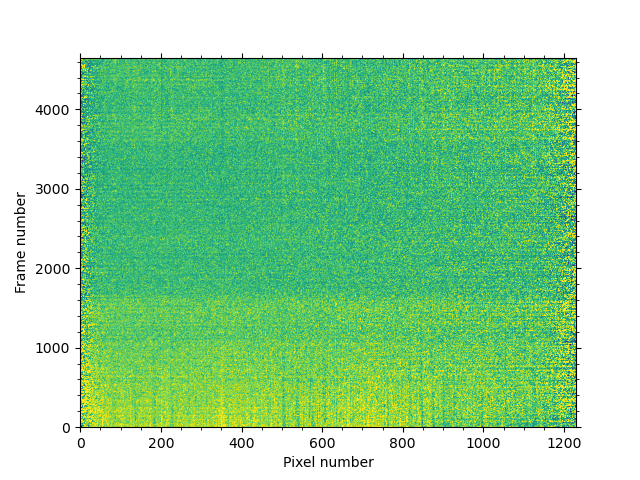

In [9]:
plt.figure()

normalised_spectra = s1/np.median(s1,axis=0)

vmin,vmax = np.percentile(normalised_spectra,[10,70])

plt.imshow(normalised_spectra,vmin=vmin,vmax=vmax,aspect="auto")
plt.xlabel("Pixel number")
plt.ylabel("Frame number")
plt.savefig("transit_imshow.png",dpi=180)
plt.show()

Weird pre and post-transit stripes

Perform the cosmic search on normalised spectra

In [10]:
s1_norm = np.array([i/np.nanmean(i) for i in s1])

Check to see how bad frames are first

<IPython.core.display.Javascript object>


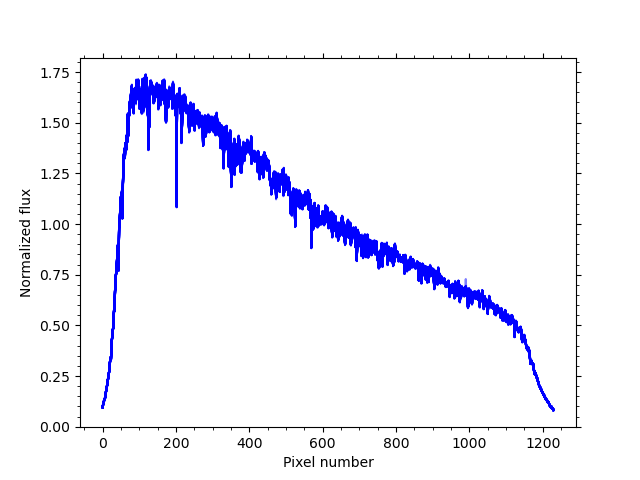

In [11]:
plt.figure()
for i in s1_norm[::100]:
    plt.plot(i,'b',alpha=0.5)
plt.xlabel("Pixel number")
plt.ylabel("Normalized flux")
plt.show()

Perhaps a bad pixel at 202 but otherwise looks OK

In [12]:
plt.close("all")

<IPython.core.display.Javascript object>


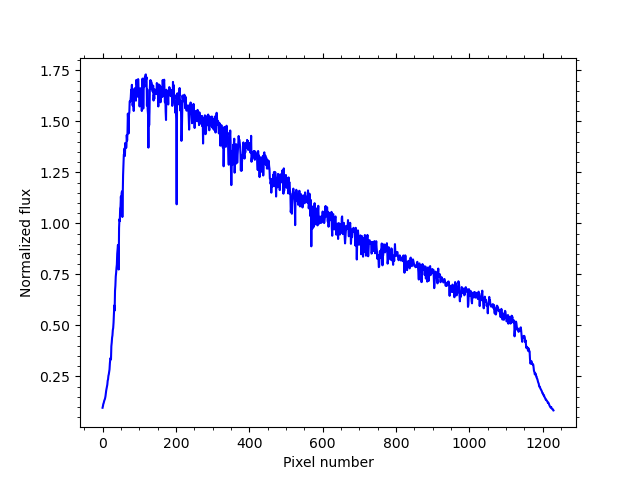

In [13]:
ref_frame = np.nanmedian(s1_norm,axis=0)

nframes = len(s1)

plt.figure()
plt.plot(ref_frame,color='b')
plt.xlabel("Pixel number")
plt.ylabel("Normalized flux")
plt.show()

Cleaning cosmics iteratively for the first time

In [14]:
help(c.replace_cosmics)

Help on function replace_cosmics in module reduction_utils.cosmic_removal:

replace_cosmics(spectra, errors, cosmic_frames, cosmic_positions, replace_with_nans=False)
    Replaces the cosmic pixels by a linear fit between the 2 nearest, unaffected, pixels.
    
    Inputs:
    spectra - ndarray of all 1D spectra, with and without cosmics flagged
    errors - ndarray of 1D spectra's errors
    cosmic_frames - the array of frames flagged as containing cosmics
    cosmic_positions - ndarray of locations of pixels flagged as cosmics
    replace_with_nans - if wanting to replace the cosmic rays with nans instead of interpolation use this.
    
    Returns:
    np.array(clean_flux) - the ndarray of 1D spectra following removal of the cosmics
    np.array(clean_error) - the ndarray of 1D errors following removal of the cosmics



<IPython.core.display.Javascript object>


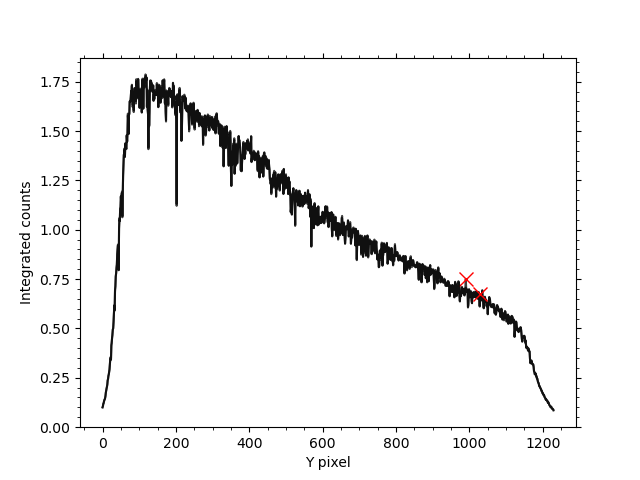

Post-cleaning


<IPython.core.display.Javascript object>


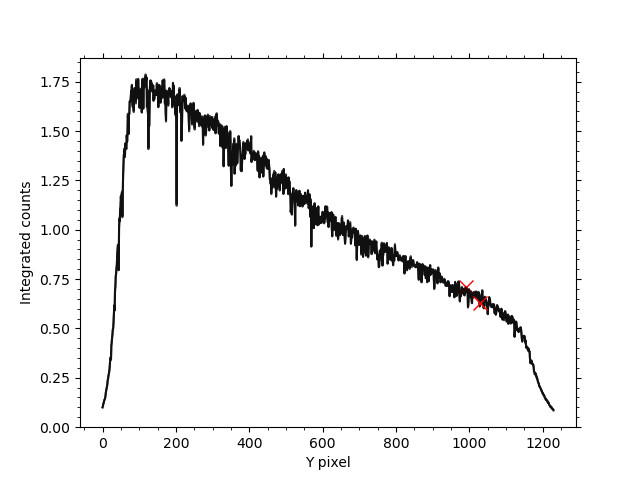

In [15]:
plt.close("all")

cleaned_flux = s1.copy()
cleaned_err = e1.copy()

ref_frame = np.nanmedian(cleaned_flux,axis=0)

cosmic_frames,cosmic_pixels = c.find_cosmic_frames(cleaned_flux,ref_frame,clip=10,mad=False,verbose=False,\
                                                       ignore_edges=10)

c.check_cosmic_frames(wc.normalise(cleaned_flux),cosmic_frames,cosmic_pixels,single_plot=True)

cleaned_flux,cleaned_err = c.replace_cosmics(cleaned_flux,cleaned_err,cosmic_frames,cosmic_pixels,\
                                             replace_with_nans=False)

print("Post-cleaning")
c.check_cosmic_frames(wc.normalise(cleaned_flux),cosmic_frames,cosmic_pixels,single_plot=True)

I actually don't think that it is worth the cosmic clipping here.

In [16]:
fwhm = pickle.load(open("../pickled_objects/fwhm_1.pickle","rb"))
xpos = pickle.load(open("../pickled_objects/x_positions_1.pickle","rb"))
sky = pickle.load(open("../pickled_objects/sky_avg_star1.pickle","rb"))

fwhm_norm = (fwhm-fwhm.mean())/fwhm.std()
xpos_norm = (xpos.sum(axis=1)-xpos.sum(axis=1).mean())/xpos.sum(axis=1).std()
sky_norm = (sky.sum(axis=1)-sky.sum(axis=1).mean())/sky.sum(axis=1).std()

In [17]:
fwhm_outliers = ~((fwhm_norm <= 3*np.std(fwhm_norm)) & (fwhm_norm >= -3*np.std(fwhm_norm)))
xpos_outliers = ~((xpos_norm <= 3*np.std(xpos_norm)) & (xpos_norm >= -3*np.std(xpos_norm)))
sky_outliers = ~((sky_norm <= 3*np.std(sky_norm)) & (sky_norm >= -3*np.std(sky_norm)))

In [18]:
all_outliers = fwhm_outliers.astype(int) + xpos_outliers.astype(int) + sky_outliers.astype(int)
common_outliers = all_outliers >= 2

<IPython.core.display.Javascript object>


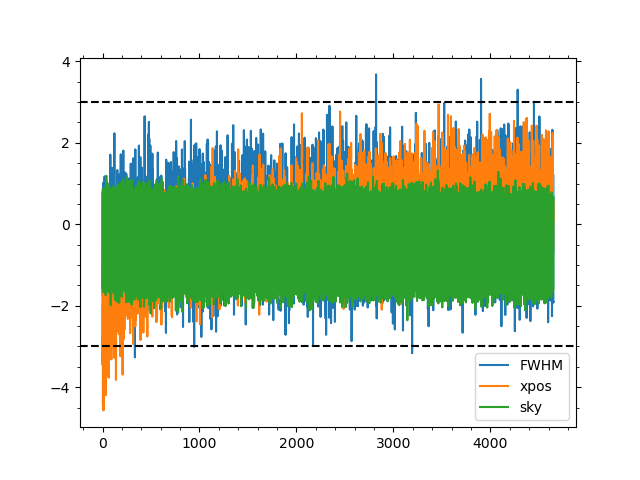

In [19]:
plt.figure()
plt.plot(fwhm_norm,label="FWHM")
plt.plot(xpos_norm,label="xpos")
plt.plot(sky_norm,label="sky")

# note, since these are standardized, 3 sigma outliers have a value > 3
plt.axhline(3,color='k',ls='--')
plt.axhline(-3,color='k',ls='--')

# plt.xlim(20730,20780)
plt.legend()
plt.show()


There are no consistently off data point so I think it's fair to assume there was no high gain antenna move here. 

However, the drops in sky background might need to be removed from the time-series of flux data points.

There is a fairly large shift in xpos